In [91]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score



#1. Exploration des données

In [57]:
# 1. Chargement des données
data = pd.read_excel('/content/test_technique_dataset.xlsx')
data.shape

(20830, 9)

In [58]:
# 2. Aperçu des données
# Affichage des premières lignes du dataset pour avoir une idée générale de ce qu'il contient
print(data.head())

   id_client job_category  service_channel nb_internet_products  \
0          1         8690              PRO                    2   
1          2         8690              PRO                    1   
2          3        7022Z  BUREAU DE POSTE                    1   
3          4        4399C  BUREAU DE POSTE                    0   
4          5        9609Z              PRO                    2   

   contract_type risk_of_credit      credit_flux  annual_flux  target  
0              1              8  0 a 70% de flux     20903.81       0  
1              1              7  0 a 70% de flux      5192.50       0  
2              1              6      Pas de flux          NaN       0  
3              1           CESS  0 a 70% de flux        33.40       0  
4              1              7  0 a 70% de flux     13910.00       0  


In [59]:
# 3. Informations générales sur les colonnes
# Cela nous donne une idée des types de données, du nombre de valeurs non nulles, etc.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20830 entries, 0 to 20829
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_client             20830 non-null  int64  
 1   job_category          20018 non-null  object 
 2   service_channel       20830 non-null  object 
 3   nb_internet_products  20829 non-null  object 
 4   contract_type         20830 non-null  int64  
 5   risk_of_credit        16063 non-null  object 
 6   credit_flux           20829 non-null  object 
 7   annual_flux           13346 non-null  float64
 8   target                20830 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ MB
None


In [60]:
# 4. Statistiques descriptives
# Cela nous donne des informations comme la moyenne, l'écart-type, le min/max, etc. pour chaque colonne numérique
print(data.describe())

          id_client  contract_type   annual_flux        target
count  20830.000000   20830.000000  1.334600e+04  20830.000000
mean   10415.500000       1.095439  9.990473e+05      0.088910
std     6013.247389       6.428571  3.354726e+07      0.284621
min        1.000000       0.000000  9.000000e-02      0.000000
25%     5208.250000       1.000000  3.899445e+03      0.000000
50%    10415.500000       1.000000  1.138912e+04      0.000000
75%    15622.750000       1.000000  3.193261e+04      0.000000
max    20830.000000     682.000000  2.272004e+09      1.000000


In [61]:
# 5. Vérification des valeurs manquantes
# Ceci nous aidera à décider comment traiter ces valeurs plus tard
print(data.isnull().sum())

id_client                  0
job_category             812
service_channel            0
nb_internet_products       1
contract_type              0
risk_of_credit          4767
credit_flux                1
annual_flux             7484
target                     0
dtype: int64


In [62]:
# 6. Exploration des variables catégorielles
print(data['job_category'].value_counts())

6820B      1485
8690        854
7022Z       487
8690E       468
9499Z       416
           ... 
6530Z         1
2016Z         1
1395Z         1
4619A         1
inconnu       1
Name: job_category, Length: 600, dtype: int64


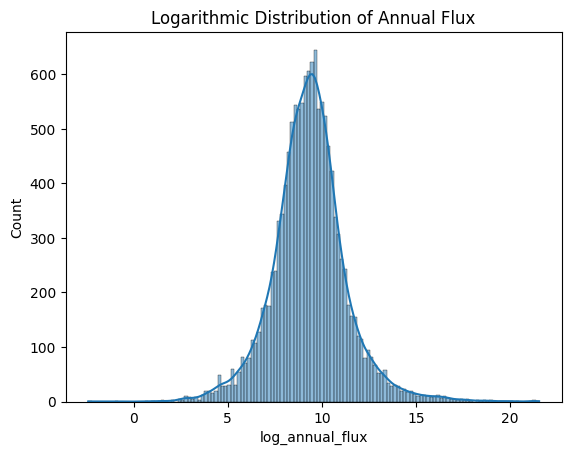

In [63]:
# 7. Visualisations

# Distribution de la variable 'annual_flux'
# Utiliser une échelle logarithmique pour mieux visualiser
data['log_annual_flux'] = data['annual_flux'].apply(lambda x: 0 if x == 0 else np.log(x))
sns.histplot(data['log_annual_flux'], kde=True)
plt.title('Logarithmic Distribution of Annual Flux')
plt.show()

In [64]:
# Supprimons la colonne log_annual_flux pour garder le jeu de données original propre.
data.drop('log_annual_flux', axis=1, inplace=True)

<ipython-input-65-db2cd3555f8c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


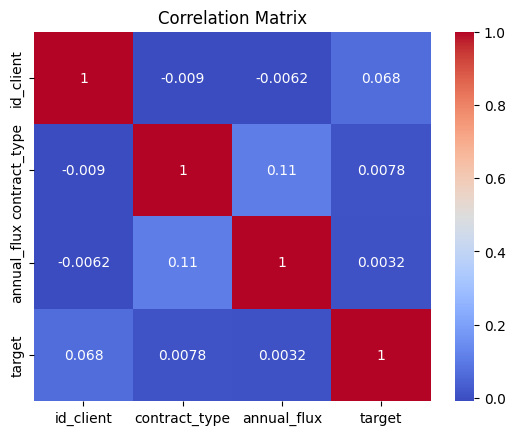

In [65]:
# Matrice de corrélation
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2. Analyse des données


In [66]:
# 1. Traitement des valeurs manquantes
# Remplacer les valeurs manquantes des colonnes numériques par la médiane
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

In [67]:
# Vérification
print(data.isnull().sum())

id_client                  0
job_category             812
service_channel            0
nb_internet_products       1
contract_type              0
risk_of_credit          4767
credit_flux                1
annual_flux                0
target                     0
dtype: int64


In [68]:
# Remplacer les valeurs manquantes des colonnes catégorielles par la mode
categorical_cols = data.select_dtypes(include=[object]).columns.tolist()
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [69]:
# Vérification
print(data.isnull().sum())
data.dtypes

id_client               0
job_category            0
service_channel         0
nb_internet_products    0
contract_type           0
risk_of_credit          0
credit_flux             0
annual_flux             0
target                  0
dtype: int64


id_client                 int64
job_category             object
service_channel          object
nb_internet_products     object
contract_type             int64
risk_of_credit           object
credit_flux              object
annual_flux             float64
target                    int64
dtype: object

In [70]:
data['target'].value_counts()

0    18978
1     1852
Name: target, dtype: int64

In [71]:
# 3. Encodage des variables catégorielles
# Encodage One-Hot pour transformer les colonnes catégorielles en format numérique
data = pd.get_dummies(data, drop_first=True)

In [72]:
# Vérification
print(data.isnull().sum())
data.dtypes

id_client                          0
contract_type                      0
annual_flux                        0
target                             0
job_category_1071                  0
                                  ..
risk_of_credit_XXXX                0
credit_flux_0 a 70% de flux        0
credit_flux_Inconnu                0
credit_flux_Pas de flux            0
credit_flux_Plus de 70% de flux    0
Length: 659, dtype: int64


id_client                            int64
contract_type                        int64
annual_flux                        float64
target                               int64
job_category_1071                    uint8
                                    ...   
risk_of_credit_XXXX                  uint8
credit_flux_0 a 70% de flux          uint8
credit_flux_Inconnu                  uint8
credit_flux_Pas de flux              uint8
credit_flux_Plus de 70% de flux      uint8
Length: 659, dtype: object

In [73]:
# 5.  Division du dataset

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.to_csv('train.csv', index=False)
y.to_csv('test.csv', index=False)

In [74]:
# 6.  Utilisation de SMOTE pour équilibrer les classes
print("Distribution des classes avant SMOTE :")
print(y_train.value_counts())

Distribution des classes avant SMOTE :
0    14235
1     1387
Name: target, dtype: int64


In [75]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [76]:
print("Distribution des classes après SMOTE :")
print(y_train_smote.value_counts())

Distribution des classes après SMOTE :
0    14235
1    14235
Name: target, dtype: int64


# 3. Modélisation et performance



In [85]:
# Choix du modèle : XGBoost avec des hyperparamètres de base

#clf = RandomForestClassifier(random_state=42)
#clf.fit(X_train_smote, y_train_smote)

#clf = XGBClassifier(random_state=42)
#clf.fit(X_train_smote, y_train_smote)


ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)  # ratio of negative to positive samples

clf_xgb = xgb.XGBClassifier(
    scale_pos_weight=ratio,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False
)

In [86]:
clf_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [89]:
y_pred_xgb = clf_xgb.predict(X_test)
cm=confusion_matrix(y_test, y_pred_xgb)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))

[[3948  795]
 [  98  367]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      4743
           1       0.32      0.79      0.45       465

    accuracy                           0.83      5208
   macro avg       0.65      0.81      0.67      5208
weighted avg       0.92      0.83      0.86      5208

AUC-ROC: 0.8108159392789374


In [ ]:
# Sauvegarde des prédictions
predictions_df = pd.DataFrame(y_pred_xbg, columns=['prediction'])
predictions_df.to_csv('predictions.csv', index=False)

In [90]:
# Sauvegarde de la matrice de confusion
confusion_df = pd.DataFrame(cm)
confusion_df.to_csv('confusion_matrix.csv', index=False)